In [4]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2025-01-01 19:52:22--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 

200 OK
Length: 1115394 (1,1M) [text/plain]
Saving to: ‘input.txt.1’

input.txt.1         100%[===================>]   1,06M   690KB/s    in 1,6s    

2025-01-01 19:52:24 (690 KB/s) - ‘input.txt.1’ saved [1115394/1115394]



In [6]:
from model import Za_kar_yan_GPT

In [7]:
import json
from dataclasses import dataclass
@dataclass
class Config:

    heads: int
    dropout: float
    embedding_size: int
    dict_size: int
    attention_dropout: float
    hidden_layer_size: int
    N_blocks: int



    @staticmethod
    def from_json_file(filepath: str) -> 'Config':
        with open(filepath, 'r') as file:
          data = json.load(file)
          return Config(**data)

config = Config.from_json_file('config/config.json')

In [8]:
model = Za_kar_yan_GPT(config)
model

Za_kar_yan_GPT(
  (embedding): Embedding(50259, 512)
  (position_emb): Embedding(50259, 512)
  (blocks): Sequential(
    (0): Block(
      (att): MultiHeadAttention(
        (query): Linear(in_features=512, out_features=512, bias=False)
        (key): Linear(in_features=512, out_features=512, bias=False)
        (value): Linear(in_features=512, out_features=512, bias=False)
        (att_dropout): Dropout(p=0.1, inplace=False)
        (linear): Linear(in_features=512, out_features=512, bias=True)
        (after_linear_dropout): Dropout(p=0.1, inplace=False)
      )
      (layernorm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (mlp): FullyConnected(
        (linear1): Linear(in_features=512, out_features=2560, bias=True)
        (activation): GELU(approximate='tanh')
        (linear2): Linear(in_features=2560, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (layernorm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  

In [9]:
!nvidia-smi

Wed Jan  1 23:52:33 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        Off | 00000000:01:00.0 Off |                  Off |
|  0%   41C    P8              19W / 450W |  13367MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [10]:
with open('input.txt') as f:
    text = f.read()

In [11]:
import random
import re
def split_all_text_into_chunks(text, begin, end):
    chunks = []
    splitted_text = re.split(r'\n\n', text)

    
    pointer = 0
    while pointer < len(splitted_text):
        random_int = random.randint(begin, end)
        chunks.append('\n\n'.join(splitted_text[pointer: min(pointer+random_int, len(splitted_text))]))
        pointer += random_int

    return chunks

In [12]:
chunks = split_all_text_into_chunks(text, 1, 2)

In [13]:
from transformers import GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2", bos_token='<|beginoftext|>', pad_token='<|padding|>')


In [14]:
from typing import List, Tuple
def preprocess_data(chunks: List[List[str]]) -> Tuple[List[List[str]], List[List[int]]]:
    

    bos_token = tokenizer.bos_token_id
    chunks_ids = []
    for chunk in chunks:
        ids = [bos_token] + tokenizer.encode(chunk, )
        chunks_ids.append(ids)

    return chunks_ids

In [15]:
chunks_ids = preprocess_data(chunks)

In [16]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(chunks_ids, test_size=0.1)

In [17]:
sorted_train = sorted(train, key=len)

In [18]:
import torch
import random 

def generate_sorted_batches(chunks, batch_size=2):
    sorted_chunks = sorted(chunks, key=len, reverse=True)

    
    for i in range(0, len(sorted_chunks), batch_size):
        for j in range(i + 1, min(i+batch_size, len(sorted_chunks))):
            sorted_chunks[j] += [tokenizer.pad_token_id] * (len(sorted_chunks[i]) - len(sorted_chunks[j]))

        
    while True:
        random_int: int = random.choice(list(range(0, len(sorted_chunks) - batch_size, batch_size)))
        yield (torch.LongTensor(sorted_chunks[random_int:random_int+batch_size])[:, :-1],
              torch.LongTensor(sorted_chunks[random_int:random_int+batch_size])[:, 1:])

In [19]:
for tuple in generate_sorted_batches(sorted_train, batch_size=2):
    print(tuple[0].shape, tuple[1].shape)
    break

torch.Size([2, 90]) torch.Size([2, 90])


In [20]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
model.to(device);

In [21]:
next(model.parameters())

Parameter containing:
tensor([[-1.4730,  0.3786,  0.2054,  ...,  0.5609,  0.8501, -2.0746],
        [ 0.0869,  1.1776,  0.8506,  ...,  0.0262, -2.0620,  2.0986],
        [-0.0385,  0.1684,  1.3348,  ..., -0.1637, -0.6233, -0.1614],
        ...,
        [-0.1941,  0.3584,  0.6629,  ...,  0.6695,  0.6511, -1.4852],
        [ 2.3383, -0.1886, -1.8183,  ..., -1.1771,  0.2592, -0.3145],
        [ 1.4504,  1.5005,  0.6376,  ...,  0.1469, -0.2995,  0.4401]],
       device='cuda:1', requires_grad=True)

In [22]:
import torch.nn as nn 
from tqdm import tqdm
from matplotlib import pyplot as plt
from IPython.display import clear_output
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [23]:
batch_generation = generate_sorted_batches(sorted_train, batch_size=4)
model.train();

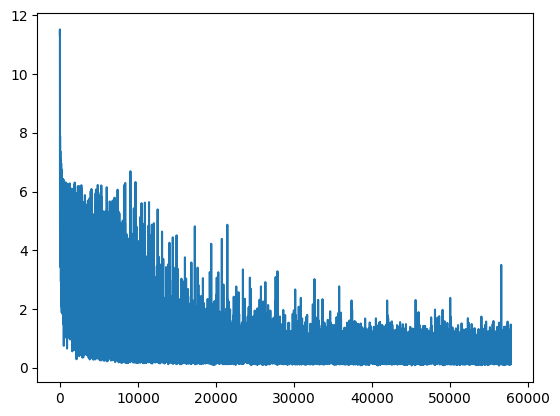

100%|██████████| 50000/50000 [32:43<00:00, 25.47it/s]


In [27]:
all_losses = []
model.to(device)
for i in tqdm(range(50000)):
   optimizer.zero_grad()
   x, y = next(batch_generation)
   x, y = x.to(device), y.to(device)
   logits = model(x)
   loss = criterion(logits.transpose(1, 2), y)
   all_losses.append(loss.item())
   loss.backward()    
   optimizer.step()
   if i % 100 == 0:
      clear_output(True)
      plt.plot(all_losses)
      plt.show()

In [30]:
all_losses[-10:]

[0.766266405582428,
 1.1850305795669556,
 0.6228843331336975,
 0.404852956533432,
 0.10345175117254257,
 0.44813084602355957,
 0.44824859499931335,
 0.20064839720726013,
 0.2500579357147217,
 0.4217204451560974]

In [81]:
model.eval()

@torch.no_grad()
def generate(idx, max_new_tokens, temperature=1.0, top_k=None):
    
    for _ in range(max_new_tokens):

        logits = model(idx)
        logits = logits[:, -1, :] / temperature
        probs = torch.nn.functional.softmax(logits, dim=-1)
        idx_next = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, idx_next), dim=1)
    idx = idx[:, 1:]
    return idx


In [82]:
inputs = tokenizer.encode('<|beginoftext|>LUCENTIO:', return_tensors='pt')
inputs

tensor([[50257,    43,  9598,  3525,  9399,    25]])

In [92]:
output = generate(inputs.to(device), 400, temperature=1)

In [93]:
print(tokenizer.decode(output[0].tolist()))

LUCENTIO:
A hundred then.

Tailor:
 like the like to live.
You shall be your daughter.
I get me, follow him right Vincentio.
Trow's hither come, in the war and dub him,
And he doth me on his greatest promise-day,
I thank my son:
What dowry, and trouble him with a groanows you not.
Dost as a sire, think you note, what with a bitter word?
How in so grub with a bened
The yourselves. He, what is the doth quit like a little heart, I hear a tear
That in the one second hour.
The heart that conn'd has sworn
Faster than tears;
That has our sea-w.

The drop
And most opportune to potherthe boy.
And twenty pound a week best, sister to't and her grave with the subjects, then how quicklyr.
That has our solemn.
That his leather which is to friend nor enemy? What stars,
The form 'Charge that there
For he in heaven
Which honour, it hath been this action.

Here comes! my sovereign, God!--

First Citizen:
Wrench-wixt them well to't,
A precious queen:
This fair?
What isle, and to wife water,
What dadd swe

In [79]:
torch.save(model.state_dict(), './Za-kar-yan-GPT.pt')